In [1]:
import torch
from torch import nn
from torch.distributions.multivariate_normal import MultivariateNormal
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as dists
import torch.utils.data as utils
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import os
import sys
import time
from collections import defaultdict
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image
import torchvision.utils as vutils
from IPython.display import clear_output
%matplotlib inline

In [2]:
class Reshape(nn.Module):
    def __init__(self, shape):
        nn.Module.__init__(self)
        self.shape=shape
    def forward(self,input):
        return input.view(self.shape)
    
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.shape[0], -1)
    
class Conv_block(nn.Module):
    def __init__(self, num_features, in_channels, out_channels, kernel_size, stride=1, padding=0, negative_slope=0.2, p=0.04, transpose=False):
        super(Conv_block, self).__init__()
        
        self.transpose = transpose
        if transpose:
            self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding)
        else:
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
            
        self.activation = nn.LeakyReLU(negative_slope, inplace=True)
        self.dropout = nn.Dropout2d(p)
        self.batch_norm = nn.BatchNorm2d(num_features)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        if not self.transpose:
            x = self.dropout(x)
        x = self.batch_norm(x)

        return x

In [18]:
class CSVAE(nn.Module):
    def __init__(self, input_shape, labels_dim, z_dim, w_dim, KOF=64, p=0.04):
        super(CSVAE, self).__init__()
        self.input_shape = input_shape
        self.labels_dim = labels_dim
        self.z_dim = z_dim
        self.w_dim = w_dim
        
        # x to x_features_dim
        self.encoder = nn.Sequential()
        self.encoder.add_module("block01", Conv_block(KOF, 3, KOF, 4, 2, 1, p=p))
        self.encoder.add_module("block02", Conv_block(KOF*2, KOF, KOF*2, 4, 2, 1, p=p))
        self.encoder.add_module("block03", Conv_block(KOF*4, KOF*2, KOF*4, 4, 2, 1, p=p))
        self.encoder.add_module("block04", Conv_block(KOF*8, KOF*4, KOF*8, 4, 2, 1, p=p))
        self.encoder.add_module("block05", Conv_block(KOF*16, KOF*8, KOF*16, 4, 2, 1, p=p))
        self.encoder.add_module("block06", Conv_block(KOF*16, KOF*16, KOF*16, 4, 2, 1, p=p))
#         self.encoder.add_module("block07", Conv_block(KOF*32, KOF*16, KOF*32, 4, 2, 1, p=p))
#         self.encoder.add_module("block08", Conv_block(KOF*32, KOF*32, KOF*32, 4, 2, 1, p=p))
        self.encoder.add_module("flatten", Flatten())
    
        x_features_dim = KOF * 8 * 2
        
        self.encoder_xy_to_w = nn.Sequential(
            nn.Linear(x_features_dim + labels_dim, w_dim), 
            nn.ReLU(), 
        )
        self.mu_xy_to_w = nn.Linear(w_dim, w_dim)
        self.logvar_xy_to_w = nn.Linear(w_dim, w_dim)
        
        self.encoder_x_to_z = nn.Sequential(
            nn.Linear(x_features_dim, z_dim), 
            nn.ReLU(), 
        )
        self.mu_x_to_z = nn.Linear(z_dim, z_dim)
        self.logvar_x_to_z = nn.Linear(z_dim, z_dim)
        
        self.encoder_y_to_w = nn.Sequential(
            nn.Linear(labels_dim, w_dim), 
            nn.ReLU(), 
#             nn.Linear(w_dim, w_dim), 
#             nn.ReLU()
        )
        self.mu_y_to_w = nn.Linear(w_dim, w_dim)
        self.logvar_y_to_w = nn.Linear(w_dim, w_dim)
        
        # Add sigmoid or smth for images!
        # (z+w) to x_sample
        # (!) no logvar for x
        self.decoder_zw_to_x = nn.Sequential()
        self.decoder_zw_to_x.add_module("block00", nn.Sequential(
            nn.Linear(z_dim+w_dim, z_dim+w_dim), 
            nn.BatchNorm1d(z_dim+w_dim), 
            nn.LeakyReLU(0.2)
        ))
        self.decoder_zw_to_x.add_module("reshape", Reshape((-1, z_dim+w_dim, 1, 1)))
        
        self.decoder_zw_to_x.add_module("block01", Conv_block(KOF*4, z_dim+w_dim, KOF*4, 4, 1, 0, p=p, transpose=True))
        self.decoder_zw_to_x.add_module("block02", Conv_block(KOF*4, KOF*4, KOF*4, 4, 2, 1, p=p, transpose=True))
        self.decoder_zw_to_x.add_module("block03", Conv_block(KOF*2, KOF*4, KOF*2, 3, 1, 1, p=p, transpose=True))
        self.decoder_zw_to_x.add_module("block04", Conv_block(KOF*2, KOF*2, KOF*2, 4, 2, 1, p=p, transpose=True))
#         self.decoder_zw_to_x.add_module("block05", Conv_block(KOF*4, KOF*4, KOF*4, 4, 2, 1, p=p, transpose=True))
#         self.decoder_zw_to_x.add_module("block06", Conv_block(KOF*2, KOF*4, KOF*2, 4, 2, 1, p=p, transpose=True))
        self.decoder_zw_to_x.add_module("block05", Conv_block(KOF, KOF*2, KOF, 4, 2, 1, p=p, transpose=True))
        self.decoder_zw_to_x.add_module("block06", Conv_block(KOF, KOF, KOF, 4, 2, 1, p=p, transpose=True))
#         self.decoder_zw_to_x.add_module("block07", nn.Sequential(
#                     nn.ConvTranspose2d(KOF, 3, 3, 1, 1)))

        self.mu_zw_to_x = nn.Sequential(
            nn.ConvTranspose2d(KOF, 3, 3, 1, 1),
            nn.Tanh()
        )
        self.logvar_zw_to_x = nn.Sequential(
            nn.ConvTranspose2d(KOF, 3, 3, 1, 1),
#             nn.Tanh()
        )
#         self.logvar_zw_to_x = nn.Linear(z_dim+w_dim, input_dim)

        # adversarial delta(z -> y)
        self.decoder_z_to_y = nn.Sequential(
            nn.Linear(z_dim, z_dim), 
            nn.ReLU(), 
            nn.Linear(z_dim, z_dim), 
            nn.ReLU(),
            nn.Linear(z_dim, labels_dim), 
            nn.Sigmoid()
        )

        self.init_params()

    def init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.xavier_normal_(m.weight.data)
        
    def q_zw(self, x, y):
        """
        VARIATIONAL POSTERIOR
        :param x: input image
        :return: parameters of q(z|x), (MB, hid_dim)
        """

        x_features = self.encoder(x)
        
        intermediate = self.encoder_x_to_z(x_features)
        z_mu = self.mu_x_to_z(intermediate)
        z_logvar = self.mu_x_to_z(intermediate)
        
        xy = torch.cat([x_features, y], dim=1)
        
        intermediate = self.encoder_xy_to_w(xy)
        w_mu_encoder = self.mu_xy_to_w(intermediate)
        w_logvar_encoder = self.mu_xy_to_w(intermediate)
        
        intermediate = self.encoder_y_to_w(y)
        w_mu_prior = self.mu_y_to_w(intermediate)
        w_logvar_prior = self.mu_y_to_w(intermediate)
        
        return w_mu_encoder, w_logvar_encoder, w_mu_prior, \
               w_logvar_prior, z_mu, z_logvar
    
    def p_x(self, z, w):
        """
        GENERATIVE DISTRIBUTION
        :param z: latent vector          (MB, hid_dim)
        :return: parameters of p(x|z)    (MB, inp_dim)
        """
        
        zw = torch.cat([z, w], dim=1)
        
        intermediate = self.decoder_zw_to_x(zw)
        mu = self.mu_zw_to_x(intermediate)
        logvar = self.logvar_zw_to_x(intermediate)
        
        return mu, logvar

    def forward(self, x, y):
        """
        Encode the image, sample z and decode 
        :param x: input image
        :return: parameters of p(x|z_hat), z_hat, parameters of q(z|x)
        """
        w_mu_encoder, w_logvar_encoder, w_mu_prior, \
            w_logvar_prior, z_mu, z_logvar = self.q_zw(x, y)
        w_encoder = self.reparameterize(w_mu_encoder, w_logvar_encoder)
        w_prior = self.reparameterize(w_mu_prior, w_logvar_prior)
        
        z = self.reparameterize(z_mu, z_logvar)
        x_mu, x_logvar = self.p_x(z, w_encoder)
        
        zw = torch.cat([z, w_encoder], dim=1) # for adversarial train
        
        y_pred = self.decoder_z_to_y(z) # for adversarial train
        
        return x_mu, x_logvar, zw, y_pred, \
               w_mu_encoder, w_logvar_encoder, w_mu_prior, \
               w_logvar_prior, z_mu, z_logvar

    def reconstruct_x(self, x, y):
        x_mu, x_logvar, zw, y_pred, w_mu_encoder, w_logvar_encoder, w_mu_prior, w_logvar_prior, z_mu, z_logvar = self.forward(x, y)
        return x_mu

    def calculate_loss(self, x, y,
                       beta1=20, beta2=1, beta3=0.2, beta4=10, beta5=1):
        """
        Given the input batch, compute the negative ELBO 
        :param x:   (MB, inp_dim)
        :param beta: Float
        :param average: Compute average over mini batch or not, bool
        :return: -RE + beta * KL  (MB, ) or (1, )
        """
        x_mu, x_logvar, zw, y_pred, w_mu_encoder, w_logvar_encoder, w_mu_prior, w_logvar_prior, z_mu, z_logvar = self.forward(x, y)
        
        # x_reconstruction_loss
        x_recon = nn.MSELoss()(x_mu, x)
        
        # w_kl
        w_dist = dists.MultivariateNormal(w_mu_encoder.flatten(), 
                                          torch.diag(w_logvar_encoder.flatten().exp()))
        w_prior = dists.MultivariateNormal(w_mu_prior.flatten(), 
                                           torch.diag(w_logvar_prior.flatten().exp()))
        w_kl = dists.kl.kl_divergence(w_dist, w_prior)
        
        # z_kl
        z_dist = dists.MultivariateNormal(z_mu.flatten(), 
                                          torch.diag(z_logvar.flatten().exp()))
        z_prior = dists.MultivariateNormal(torch.zeros(self.z_dim * z_mu.size()[0]).to(z_mu), 
                                           torch.eye(self.z_dim * z_mu.size()[0]).to(z_mu))
        z_kl = dists.kl.kl_divergence(z_dist, z_prior)
        
        # -H(y)
        y_pred_negentropy = (y_pred.log() * y_pred + (1-y_pred).log() * (1-y_pred)).mean()

        # y xentropy
        y_recon = nn.BCELoss()(y_pred, y)        # alternatively use predicted logvar too to evaluate density of input
        
        # total
        ELBO = beta1 * x_recon + beta2 * w_kl + beta3 * z_kl + beta4 * y_pred_negentropy
        return ELBO, x_recon, w_kl, z_kl, y_pred_negentropy, y_recon
        
#         if average:
#             ELBO = ELBO.mean()
#             recon = recon.mean()
#             z_kl = z_kl.mean()
#             w_kl = w_kl.mean()

#         return ELBO, recon, z_kl, w_kl


    @staticmethod
    def reparameterize(mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.FloatTensor(std.size()).normal_().to(mu.device)
        return eps.mul(std).add_(mu)

In [19]:
!nvidia-smi

Wed Oct 23 19:37:36 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:05:00.0 Off |                    0 |
| N/A   68C    P0   120W / 250W |  15019MiB / 16280MiB |     94%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  On   | 00000000:08:00.0 Off |                    0 |
| N/A   26C    P0    32W / 250W |   9153MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [20]:
device = 6

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
    
def show(file_name, img, dpi=300):
    npimg = np.transpose(img.numpy(), (1,2,0))
    plt.figure(dpi=dpi)
    plt.title(file_name, fontsize=14)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.imshow(npimg)
    plt.show()
    
def show_subplot(file_name, img):
    npimg = np.transpose(img.numpy(), (1,2,0))
    plt.title(file_name, fontsize=25)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.imshow(npimg)

def show_and_save(file_name, img, dpi=300):
    npimg = np.transpose(img.numpy(), (1,2,0))
    f = "./%s.png" % file_name
    fig = plt.figure(dpi=dpi)
    plt.title(file_name, fontsize=14)
    plt.xticks([], [])
    plt.yticks([], [])
    #plt.imshow(npimg)
    plt.imsave(f, npimg)
    
# def save_model(epoch, encoder, decoder, D):
#     torch.save(decoder.cpu().state_dict(), './VAE_GAN_decoder_%d.pth' % epoch)
#     torch.save(encoder.cpu().state_dict(),'./VAE_GAN_encoder_%d.pth' % epoch)
#     torch.save(D.cpu().state_dict(), 'VAE_GAN_D_%d.pth' % epoch)
#     decoder.to(device)
#     encoder.to(device)
#     D.to(device)
    
# def load_model(epoch, encoder, decoder, D):
#     #  restore models
#     decoder.load_state_dict(torch.load('./VAE_GAN_decoder_%d.pth' % epoch))
#     decoder.to(device)
#     encoder.load_state_dict(torch.load('./VAE_GAN_encoder_%d.pth' % epoch))
#     encoder.to(device)
#     D.load_state_dict(torch.load('VAE_GAN_D_%d.pth' % epoch))
#     D.to(device)

In [22]:
import os
import PIL
from tqdm import tqdm

In [8]:
class CelebADataset(Dataset):
    def __init__(self, imgs_path="../../img_align_celeba/img_align_celeba/img_align_celeba_cropped/", 
                 attr_path=None, transform=None, crop=False, img_names=None):
        self.imgs_path = imgs_path
        self.attr_path = attr_path
        self.transform = transform
        self.crop = crop
        self.img_names = os.listdir(self.imgs_path) if img_names is None else img_names
        
        # load dataset (whole untransformed images as np.arrays) into memory
        def get_img_array(img_path, crop=self.crop):
            img = PIL.Image.open(img_path).copy()
            if crop:
                img = img.resize((256, 256), PIL.Image.ANTIALIAS)
                img = img.crop((32, 32, 224, 224)) # crop faces
                img = img.resize((64, 64), PIL.Image.ANTIALIAS)
            return img
        
        self.attributes = None
        if attr_path is not None:
            self.attributes = pd.read_csv(attr_path)
            self.attributes = self.attributes.set_index("image_id")
            self.attributes = self.attributes.loc[img_names].values
        
        self.dataset = [get_img_array(os.path.join(self.imgs_path, i)) for i in tqdm(img_names)]

    def __getitem__(self, idx):
        img = self.dataset[idx]
        if self.transform is not None:
            img = self.transform(img) # here should be ToTensor
            
        if self.attributes is not None:
            attr = torch.FloatTensor(self.attributes[idx])
            
        return (img, attr) if self.attributes is not None else img
        # should we return attributes? (NO)
        
    def __len__(self):
        return len(self.dataset)

In [9]:
tr_te_split = pd.read_csv("../../train_val_test_split.csv")
tr_te_split

,phase,img_names
0,train,"['159267.jpg', '103476.jpg', '127216.jpg', '06..."
1,val,"['059252.jpg', '179729.jpg', '015881.jpg', '06..."
2,test,"['071574.jpg', '104018.jpg', '044147.jpg', '19..."


In [10]:
val_img_names = eval(tr_te_split.img_names[1])

In [12]:
# here we use only train data part
val_img_names = eval(tr_te_split.img_names[1])

train_dataset = CelebADataset(imgs_path="../../img_align_celeba/img_align_celeba_cropped/", 
                              attr_path="../../list_attr_celeba.csv",
                              transform=None, crop=False, img_names=val_img_names)
print(len(train_dataset))

100%|██████████| 20260/20260 [00:45<00:00, 440.79it/s]

20260


In [13]:
batch_size = 128

transform = transforms.Compose([
    transforms.ToTensor(), # заодно переставит каналы вперед (вроде)
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # это что за странная нормализация?
]) # + activation Tanh in decoder

train_dataset.transform = transform

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

torch.Size([128, 3, 64, 64])
torch.Size([128, 40])


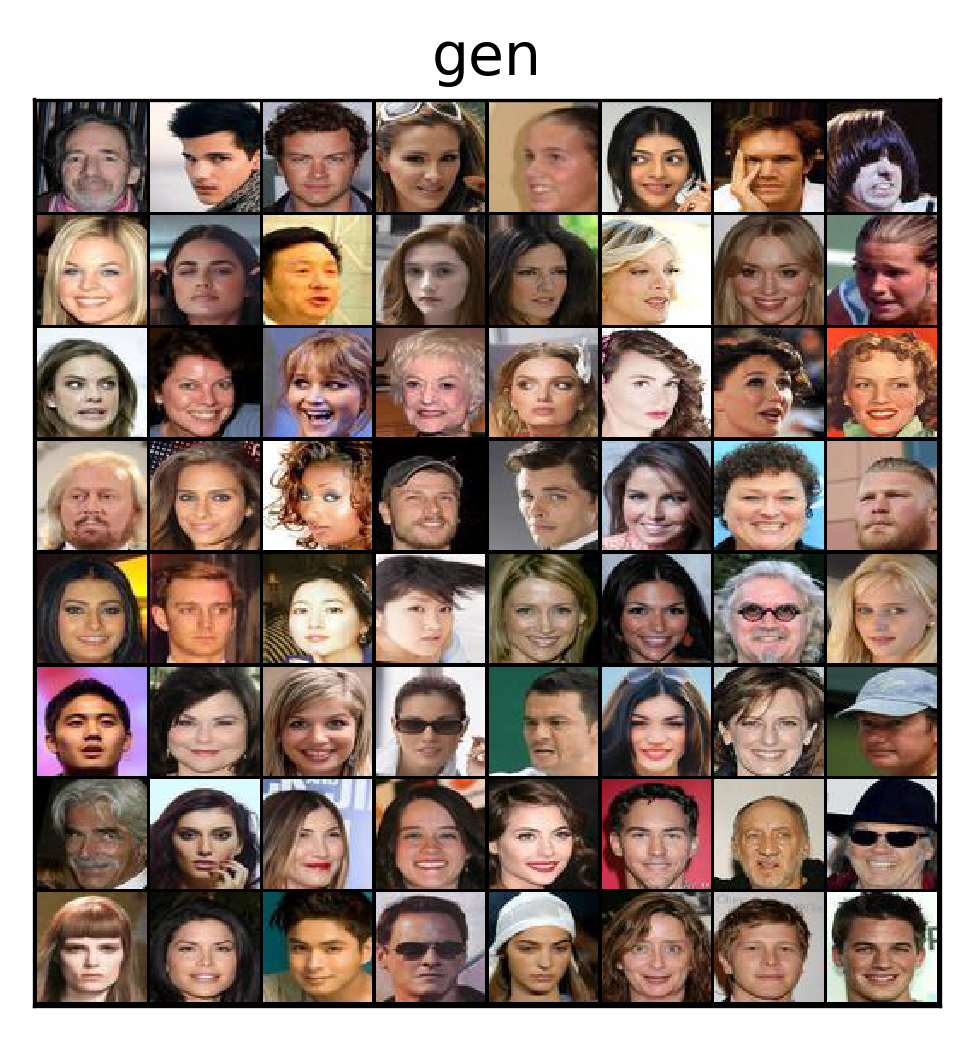

In [14]:
data, attr = next(iter(train_loader))
print(data.size())
print(attr.shape)
# print(data[1, :])
# show_and_save("gen" ,make_grid((data*0.5+0.5).cpu(),8))
show("gen", make_grid((data[:64] * 0.5 + 0.5).cpu(), 8))

In [28]:
def plot_results(epoch):
    plt.figure(figsize=(18, 5))
    plt.subplot(131)
    plt.title("MSE(X)")
    plt.plot(x_recon_losses, label="MSE(X)")
    plt.legend(loc="lower right")
    plt.subplot(132)
    plt.title("KL_Z")
    plt.plot(z_kl_losses, label="KL Z")
    plt.legend(loc="lower right")
    plt.subplot(133)
    plt.title("KL_W")
    plt.plot(w_kl_losses, label="KL W")
    plt.legend(loc="lower right")
    plt.show()
    
    plt.figure(figsize=(18, 5))
    plt.subplot(121)
    plt.title("-H(y)")
    plt.plot(y_negentropy_losses, label="-H(y)")
    plt.legend(loc="lower right")
    plt.subplot(122)
    plt.title("BCE(y)")
    plt.plot(y_recon_losses, label="BCE(y)")
    plt.legend(loc="lower right")
    plt.show()
    
    plt.figure(figsize=(20, 10), dpi=200)
    fixed_data, fixed_attr = fixed_batch
    
    plt.subplot(121)
    show_subplot('Real_epoch_%d' % epoch, make_grid((fixed_data[:16].data * 0.5 + 0.5).cpu(), 4))
    
    # here we show recovered imgs
    plt.subplot(122)
    rec_imgs = model.reconstruct_x(fixed_data.to(device), fixed_attr.to(device))
    vutils.save_image(rec_imgs.cpu().data * 0.5 + 0.5,
            os.path.join(save_imgs_path, 'rec_img_epoch_%d.png' % epoch),
            normalize=True)
    show_subplot('Rec_epoch_%d' % epoch, make_grid((rec_imgs[:16].data * 0.5 + 0.5).cpu(), 4))
    
    # here we make and save samples
#     samples = G.decoder(fixed_noise)
#     vutils.save_image(samples.data * 0.5 + 0.5,
#             os.path.join(save_imgs_path, 'sample_epoch_%d.png' % epoch),
#             normalize=True)
    
#     plt.subplot(133)
#     show_subplot('Sample_epoch_%d' % epoch, make_grid((samples[:16].data * 0.5 + 0.5).cpu(), 4))
    plt.show()

In [24]:
3 * 64 * 64

12288

In [25]:
input_shape = (3, 64, 64)
labels_dim = 40
z_dim = 64
w_dim = 64
# n_filters = 64
# latent_size = 128 # 64
max_epochs = 250
lr = 3e-4

# hopefully this makes sense
beta1 = 10000 # data_term
beta2 = 0.001 # w_kl
beta3 = 0.1 # z_kl
beta4 = 10
beta5 = 1

In [26]:
fixed_batch = next(iter(train_loader))

In [29]:
model = CSVAE(input_shape=input_shape, labels_dim=labels_dim, z_dim=z_dim, w_dim=w_dim).to(device)
model = model.train()

params_without_delta = [param for name, param in model.named_parameters() if 'decoder_z_to_y' not in name]
opt_without_delta = optim.Adam(params_without_delta, lr=lr)
scheduler_without_delta = optim.lr_scheduler.MultiStepLR(opt_without_delta, milestones=[pow(3, i) for i in range(7)], gamma=pow(0.1, 1/7))

params_delta = [param for name, param in model.named_parameters() if 'decoder_z_to_y' in name]
opt_delta = optim.Adam(params_delta, lr=lr)
scheduler_delta = optim.lr_scheduler.MultiStepLR(opt_delta, milestones=[pow(3, i) for i in range(7)], gamma=pow(0.1, 1/7))

n_epochs = max_epochs

In [ ]:
save_imgs_path = "csvae_delta_celeba_imgs_val/"

x_recon_losses = []
w_kl_losses = []
z_kl_losses = []
y_negentropy_losses = []
y_recon_losses = []
for epoch_i in range(n_epochs):
    for cur_data, cur_attr in tqdm(train_loader):
        cur_data, cur_attr = cur_data.to(device), cur_attr.to(device)
        
        loss_val, x_recon_loss_val, w_kl_loss_val, z_kl_loss_val, \
        y_negentropy_loss_val, y_recon_loss_val = model.calculate_loss(
            cur_data, cur_attr, beta1=beta1, beta2=beta2, beta3=beta3, beta4=beta4, beta5=beta5)
        
        # optimization could be done more precisely but less efficiently by only updating delta or other params on a batch
        
        opt_delta.zero_grad()
        y_recon_loss_val.backward(retain_graph=True)
        opt_delta.step()
        
        opt_without_delta.zero_grad()
        loss_val.backward()
        opt_without_delta.step()
        
        x_recon_losses.append(x_recon_loss_val.item())
        w_kl_losses.append(w_kl_loss_val.item())
        z_kl_losses.append(z_kl_loss_val.item())
        y_negentropy_losses.append(y_negentropy_loss_val.item())
        y_recon_losses.append(y_recon_loss_val.item())
    scheduler_without_delta.step()
    scheduler_delta.step()
    
    clear_output(True)
    plot_results(epoch_i)
    print('Epoch {}'.format(epoch_i))
    mean_x_recon = np.array(x_recon_losses[-len(train_loader):]).mean()
    mean_z_kl = np.array(z_kl_losses[-len(train_loader):]).mean()
    mean_w_kl = np.array(w_kl_losses[-len(train_loader):]).mean()
    mean_y_negentropy = np.array(y_negentropy_losses[-len(train_loader):]).mean()
    mean_y_recon = np.array(y_recon_losses[-len(train_loader):]).mean()
    print('Mean MSE(X): {:.4f}, scaled MSE(X): {:.4f}'.format(mean_x_recon, beta1 * mean_x_recon))
    print('Mean KL W: {:.4f}, scaled KL W: {:.4f}'.format(mean_w_kl, beta2 * mean_w_kl))
    print('Mean KL Z: {:.4f}, scaled KL Z: {:.4f}'.format(mean_z_kl, beta3 * mean_z_kl))
    print('Mean -H(y): {:.4f}, scaled -H(y): {:.4f}'.format(mean_y_negentropy, beta4 * mean_y_negentropy))
    print('Mean BCE(y): {:.4f}, scaled BCE(y): {:.4f}'.format(mean_y_recon, beta5 * mean_y_recon)) # (same)
    print()

 57%|█████▋    | 91/159 [06:59<05:13,  4.61s/it]

In [ ]:
# kl div ~ 0.01 of data_loss